# IPFP algh wiht true kl div

In [1]:
!pip install numpy matplotlib scipy scikit-learn seaborn pandas tqdm torch

In [2]:
import torch
from torch import nn
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence
import torch.nn.functional as F

import numpy as np
from scipy.stats import norm
from sklearn.datasets import make_moons, make_circles

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

## Model implementation

In [38]:
def visualize(joint_p, joint_q, n_samples=1_000):
    samples_p = MultivariateNormal(joint_p.mu, scale_tril=torch.diag(joint_p.cov)).sample([n_samples])
    samples_q = MultivariateNormal(joint_q.mu, scale_tril=torch.diag(joint_q.cov)).sample([n_samples])
    
    x, y = samples_p.chunk(2, dim=1)
    df_p = {'x': x.squeeze(), 'y': y.squeeze(), 'Distribution': 'Joint P'}
    df_p = pd.DataFrame(df_p)
    
    x, y = samples_q.chunk(2, dim=1)
    df_q = {'x': x.squeeze(), 'y': y.squeeze(), 'Distribution': 'Joint Q'}
    df_q = pd.DataFrame(df_q)
        
    sns.kdeplot(data=pd.concat([df_p, df_q]), x="x", y="y", hue='Distribution', fill=True, alpha=.6)
    plt.grid()
    plt.show()

In [39]:
class Joint(nn.Module):
    def __init__(self, in_dim, mu_fixed, div_fixed, left=True):
        super().__init__()
        # train only second half in mu prameter
        mu = torch.zeros(2 * in_dim) 
        if left: mu[:in_dim] = mu_fixed 
        else: mu[in_dim:] = mu_fixed
        self.mu = nn.Parameter(mu)

        cov = torch.ones(2 * in_dim)
        if left: cov[:in_dim] = div_fixed
        else: cov[in_dim:] = div_fixed
        self.cov = nn.Parameter(cov)
        

        # make mask of size mu
        self.mu_mask = torch.ones_like(self.mu)
        if left: self.mu_mask[:in_dim] = 0
        else: self.mu_mask[in_dim:] = 0
        self.mu.register_hook(lambda grad: grad * self.mu_mask)
        
        # make mask of size cov
        self.cov_mask = torch.ones_like(self.cov)
        if left: self.cov_mask[:in_dim] = 0
        else: self.cov_mask[in_dim:] = 0
        self.cov.register_hook(lambda grad: grad * self.cov_mask)

    def forward(self, x, y):
        x_y = torch.cat([x, y], dim=1)
        return MultivariateNormal(self.mu, scale_tril=torch.diag(self.cov)).log_prob(x_y)
    
def compute_kl_divergence(log_probs_p, log_probs_q):
    """"KL (p || q)"""
    kl_div = torch.exp(log_probs_p) * (log_probs_p - log_probs_q)
    return kl_div.sum()

    
############## TEST ##################
test_in_dim = 1
test_mu1 = -2
test_mu2 = 5
test_div = 1
test_joint1 = Joint(test_in_dim, test_mu1, test_div, left=True)
test_joint2 = Joint(test_in_dim, test_mu2, test_div, left=False)

test_x = torch.rand((32, test_in_dim))
test_y = torch.rand((32, test_in_dim))

log_probs1 = test_joint1(test_x, test_y)
log_probs2 = test_joint2(test_x, test_y)

compute_kl_divergence(log_probs1, log_probs2).backward()
print(test_joint2.mu.grad)
print(test_joint2.cov.grad)
test_joint2.cov.shape

tensor([-0.0758,  0.0000])
tensor([0.1355, -0.0000])


torch.Size([2])

In [50]:
class IPFPTrainer:
    def __init__(self, batch_size, joint_p, joint_q, lr_mu=1e-4, lr_cov=1e-4):
        self.batch_size = batch_size

        self.joint_p = joint_p
        self.joint_q = joint_q

        self.optim_mu = torch.optim.Adam([{'params': joint_p.mu}, {'params': joint_q.mu}], lr=lr_mu)
        self.optim_cov = torch.optim.Adam([{'params': joint_p.cov}, {'params': joint_q.cov}], lr=lr_cov)
   
        
    def train(self, epochs=200, verbose=10):
        losses = {'joint_p': [], 'joint_q': []}

        for epoch in range(epochs):
            avg_loss_joint_p, avg_loss_joint_q = 0, 0
            x, y = MultivariateNormal(self.joint_p.mu, scale_tril=torch.diag(self.joint_p.cov)).sample([self.batch_size]).chunk(2, dim=1)
            # x, y = batch
            loss_joint_p = self._backward_step(x, y)
            avg_loss_joint_p += loss_joint_p
                            
            # for batch in dataloader:
            # x, y = batch
            x, y = MultivariateNormal(self.joint_q.mu, scale_tril=torch.diag(self.joint_q.cov)).sample([self.batch_size]).chunk(2, dim=1)
            loss_joint_q = self._forward_step(x, y)
            avg_loss_joint_q += loss_joint_q
            
            losses['joint_p'].append(avg_loss_joint_p / self.batch_size)
            losses['joint_q'].append(avg_loss_joint_q / self.batch_size)
            
            if (epoch + 1) % verbose == 0:
                visualize(self.joint_p, self.joint_q)
                print(f'Iteration: {epoch + 1}; joint_p: {losses["joint_p"][-1]}; joint_q: {losses["joint_q"][-1]}')
        return losses
        
    def _backward_step(self, x, y):
        self.optim_mu.zero_grad()
        self.optim_cov.zero_grad()
        log_probs_p = self.joint_p(x, y)
        with torch.no_grad():
            log_probs_q = self.joint_q(x, y)
        loss_joint = compute_kl_divergence(log_probs_p, log_probs_q)
        loss_joint.backward()
        self.optim_mu.step()
        self.optim_cov.step()
        return loss_joint.detach().cpu().item()

    def _forward_step(self, x, y):
        self.optim_mu.zero_grad()
        self.optim_cov.zero_grad()
        log_probs_q = self.joint_q(x, y)
        with torch.no_grad():
            log_probs_p = self.joint_p(x, y)
        loss_joint = compute_kl_divergence(log_probs_q, log_probs_p)
        loss_joint.backward()
        self.optim_mu.step()
        self.optim_cov.step()
        return loss_joint.detach().cpu().item()

## Dataloader

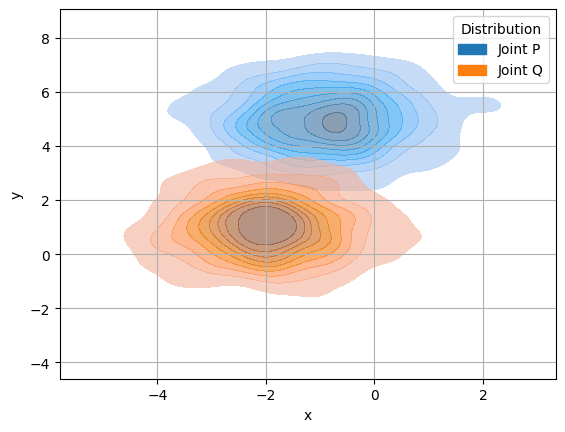

Iteration: 100; joint_p: 0.6912046463213762; joint_q: 0.6836197249420449


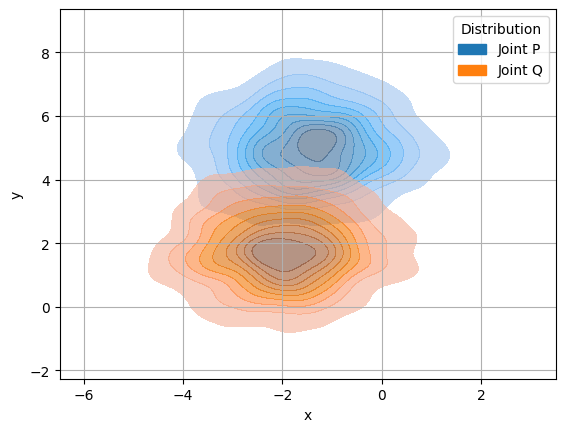

Iteration: 200; joint_p: 0.3975607861304295; joint_q: 0.4101417731400988


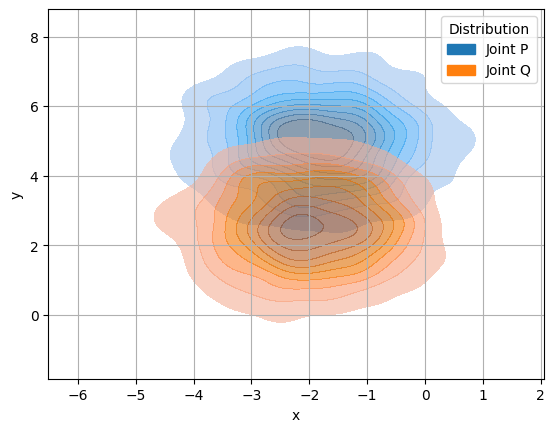

Iteration: 300; joint_p: 0.22431721647755; joint_q: 0.23615091751120973


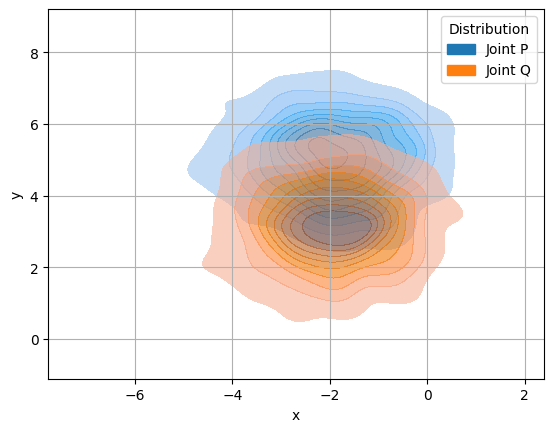

Iteration: 400; joint_p: 0.1234013197653581; joint_q: 0.13220882089967667


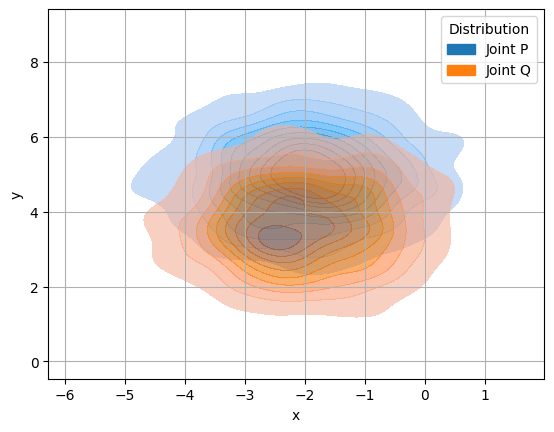

Iteration: 500; joint_p: 0.0653715640990079; joint_q: 0.06854589861622666


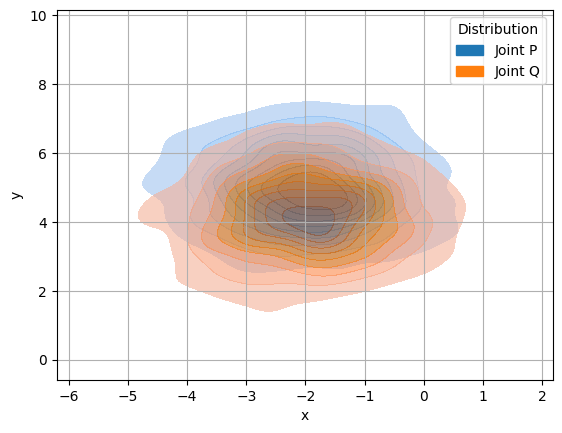

Iteration: 600; joint_p: 0.030762482061800343; joint_q: 0.033442972461557086


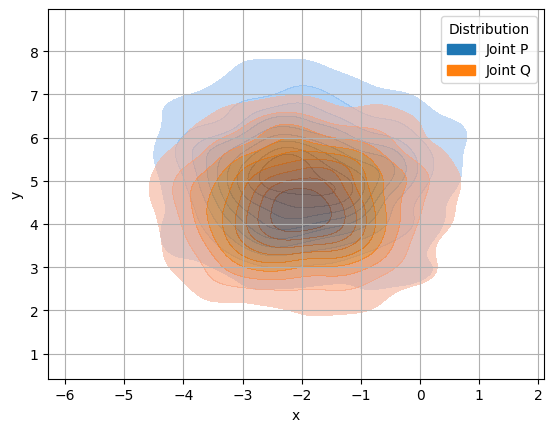

Iteration: 700; joint_p: 0.014400313690617469; joint_q: 0.015886642806061075


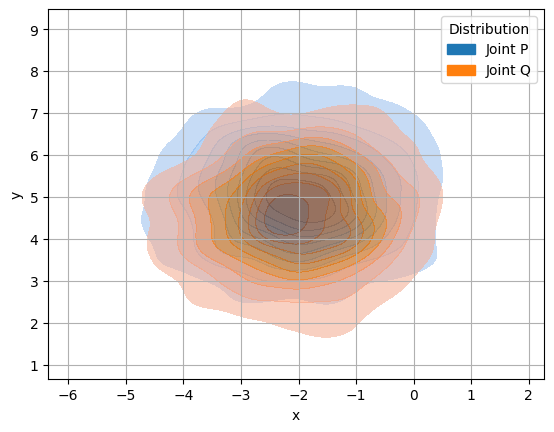

Iteration: 800; joint_p: 0.006627901523156303; joint_q: 0.006410514976758384


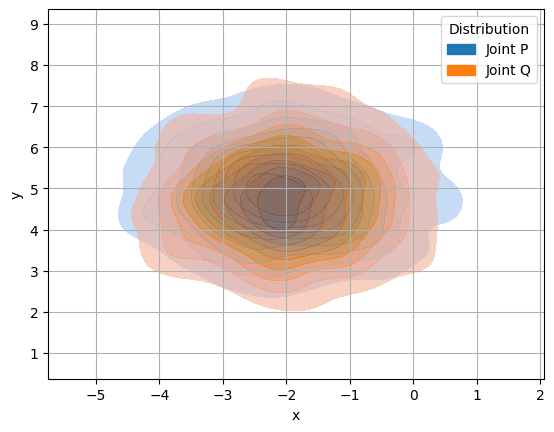

Iteration: 900; joint_p: 0.002100029941184629; joint_q: 0.0023950141135979535


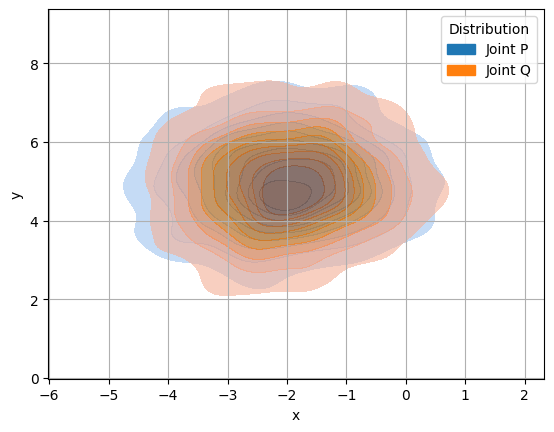

Iteration: 1000; joint_p: 0.0009076548181201494; joint_q: 0.0009639112468810707


In [64]:
# Models parameters
data_dim = 1

mu_p = 5
mu_q = -2
div_p = 1
div_q = 1

joint_p = Joint(data_dim, mu_p, div_p, left=False)
joint_q = Joint(data_dim, mu_q, div_q, left=True)

# Trainer and dataloader parameters
batch_size = 4098

trainer = IPFPTrainer(
    batch_size,
    joint_p,
    joint_q,
    lr_mu=1e-2,
    lr_cov=1e-4
)
losses = trainer.train(epochs=1000, verbose=100)

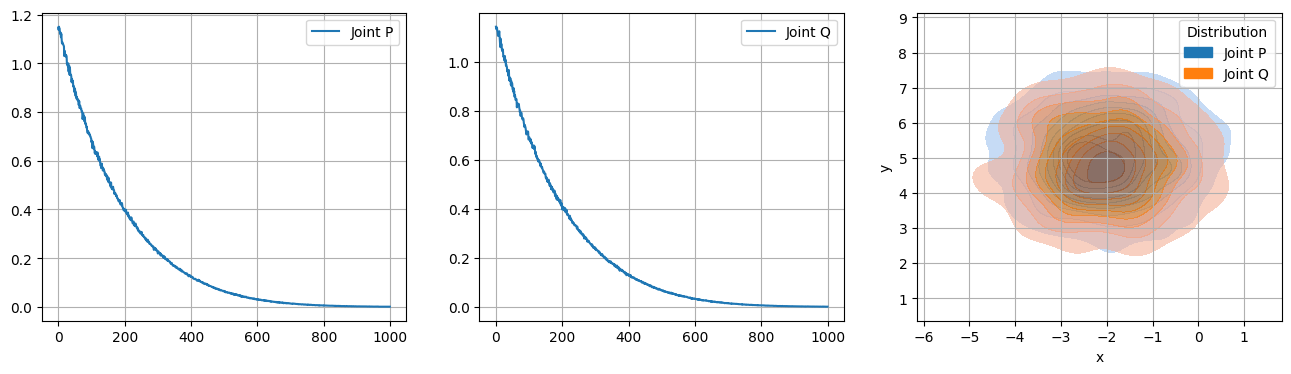

True x: mu=-2, std=1
True y: mu=5, std=1
q(x, y): mu=tensor([-2.0000,  4.8524]), std=tensor([1.0000, 1.0396])
p(x, y): mu=tensor([-1.9996,  5.0000]), std=tensor([1.0392, 1.0000])


In [65]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
# Plot losses
axs[0].plot(losses['joint_p'], label='Joint P')
axs[0].grid() 
axs[0].legend()

axs[1].plot(losses['joint_q'], label='Joint Q')
axs[1].grid()
axs[1].legend()

# Plot samples 
visualize(joint_p, joint_q)
plt.show()

print(f'True x: mu={-2}, std={1}')
print(f'True y: mu={5}, std={1}')
print(f'q(x, y): mu={joint_q.mu.detach()}, std={(joint_q.cov).detach()}')
print(f'p(x, y): mu={joint_p.mu.detach()}, std={(joint_p.cov).detach()}')